## Additional Results DeepSeek

In [1]:
import os
import re
import pandas as pd
import json

folder_path = "/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Additional_Results/evaluation_topkp_sampling"

dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r") as file:
            print(filename)
            records = []
            for line in file:
                line = line.strip()
                if not line:
                    continue
                try:
                    record = json.loads(line)
                    records.append(record)
                except json.JSONDecodeError as e:
                    print(f"[WARNING] Skipping bad line in {filename}: {e}")
            df = pd.DataFrame(records)
            df["model_name"] = filename
            if "accuracy" in df.columns:
                df["accuracy"] = df["accuracy"].astype(float)
            else:
                df["accuracy"] = df.apply(
                    lambda row: (
                        row[f"{row['category']}_accuracy"]
                        if f"{row['category']}_accuracy" in df.columns
                        else None
                    ),
                    axis=1,
                )
            df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
            df["temperature"] = df["temperature"].apply(
                lambda x: round(x, 2) if pd.notna(x) else x
            )
            columns_to_keep = ["model_name", "temperature", "category", "accuracy"]
            df = df[columns_to_keep]
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
# df = df.dropna(subset=["accuracy"])

evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Mixtral-8x7B-Instruct-v0.1-awq__20250412_105006_r_1.0_p_1.0_k_10_ICL.jsonl
evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Llama-3.1-8B-Instruct-awq__20250409_134146_r_0.0_p_0.9_k_10_SUMM.jsonl
evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Mixtral-8x7B-Instruct-v0.1-awq__20250408_132614_r_0.0_p_0.9_k_2_MT.jsonl
evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Mixtral-8x7B-Instruct-v0.1-awq__20250412_030049_r_0.0_p_1.0_k_10_CR.jsonl
evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Llama-3.1-8B-Instruct-awq__20250408_123724_r_0.0_p_0.8_k_5_SUMM.jsonl
evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Llama-3.1-8B-Instruct-awq__20250409_195855_r_0.0_p_1.0_k_10_IF.jsonl
[WARNING] Skipping bad line in evaluated_Llama-3.3-70B-Instruct_vllm_exp_dataset_csv_Llama-3.1-8B-Instruct-awq__20250409_195855_r_0.0_p_1.0_k_10_IF.jsonl: Unterminated string starting at: line 1 column 1200 (char 1199)
evaluated_Llama-3.3-70B-I

In [2]:
import pandas as pd
import re


def parse_model_name(name):
    # 去掉前缀
    name = name.replace("evaluated_", "")
    # 以 '__' 分隔，分成模型信息和参数部分
    parts = name.split("__")
    if len(parts) < 2:
        return None
    model_info = parts[0]
    params = parts[1]
    # 提取参数
    r_match = re.search(r"r_([0-9.]+)", params)
    p_match = re.search(r"p_([0-9.]+)", params)
    k_match = re.search(r"k_([0-9]+)", params)
    r = float(r_match.group(1)) if r_match else None
    p = float(p_match.group(1)) if p_match else None
    k = int(k_match.group(1)) if k_match else None
    # 提取评估模型和测试模型
    models = model_info.split("_vllm_exp_dataset_csv_")
    if len(models) < 2:
        return None
    evaluated_model = models[0]
    tested_model = models[1]
    return {
        "evaluated_model": evaluated_model,
        "tested_model": tested_model,
        "repetition_penalty": r,
        "top_p": p,
        "top_k": k,
    }


# 假设你的 df 已经有 'model_name' 这一列
# df = pd.DataFrame({'model_name': model_names})

parsed_data = df["model_name"].apply(parse_model_name)
parsed_df = pd.DataFrame(parsed_data.tolist())

In [3]:
df = pd.concat([df, parsed_df], axis=1)

In [4]:
print(df.top_p.value_counts())
print(df.repetition_penalty.value_counts())
print(df.top_k.value_counts())

# df[df["tested_model"] == "Llama-3.1-8B-Instruct-awq"].groupby(
#     ["tested_model", "top_p", "repetition_penalty", "top_k"]
# ).count()

# df[df["tested_model"] == "Llama-3.2-1B-Instruct-awq"].groupby(["tested_model", "top_p", "repetition_penalty", "top_k"]).count()

# df[df["tested_model"] == "Mixtral-8x7B-Instruct-v0.1-awq"].groupby(
#     ["tested_model", "top_p", "repetition_penalty", "top_k"]
# ).count()

df.groupby(["tested_model", "top_p", "repetition_penalty", "top_k", "category"])
df.loc[df["category"] == "MT", "accuracy"] = (
    df.loc[df["category"] == "MT", "accuracy"] / 100
)

top_p
0.8    290758
1.0    286545
0.9    285303
Name: count, dtype: int64
repetition_penalty
1.0    289182
2.0    288740
0.0    284684
Name: count, dtype: int64
top_k
2     294090
10    285254
5     283262
Name: count, dtype: int64


In [5]:
df.groupby(["tested_model", "top_p", "repetition_penalty", "top_k", "category"])

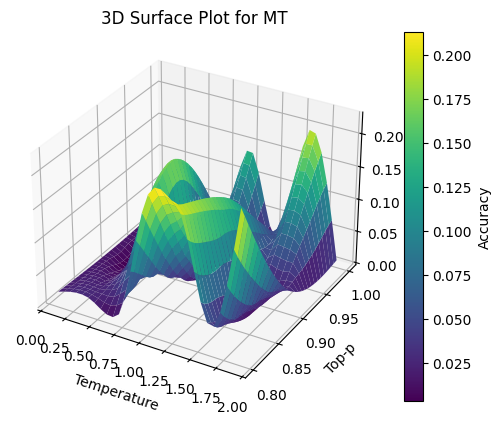

In [ ]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

category = "MT"
df_cat = df[df["category"] == category]

# 网格化数据
grid_x, grid_y = np.meshgrid(
    np.linspace(df_cat["temperature"].min(), df_cat["temperature"].max(), 30),
    np.linspace(df_cat["top_p"].min(), df_cat["top_p"].max(), 30),
)

grid_z = griddata(
    (df_cat["temperature"], df_cat["top_p"]),
    df_cat["accuracy"],
    (grid_x, grid_y),
    method="cubic",
)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap="viridis")

ax.set_xlabel("Temperature")
ax.set_ylabel("Top-p")
ax.set_zlabel("Accuracy")
plt.title(f"3D Surface Plot for {category}")
fig.colorbar(surf, label="Accuracy")
plt.show()

In [ ]:
import plotly.graph_objects as go
from scipy.interpolate import griddata
import numpy as np

category = "MT"
top_k_values = [2, 5, 10]

top_p = 0.9
repetition_penalty = 1.1

# 初始化 figure
fig = go.Figure()

# 给每个 top_k 值画一个 surface
for top_k in top_k_values:
    df_sub = df[
        (df["category"] == category)
        & (df["top_k"] == top_k)
        & (df["top_p"] == top_p)
        & (df["repetition_penalty"] == repetition_penalty)
    ]

    if len(df_sub) < 3:  # 插值需要至少三个点
        continue

    # 构建网格并插值
    grid_x, grid_y = np.meshgrid(
        np.linspace(df_sub["temperature"].min(), df_sub["temperature"].max(), 30),
        np.linspace(df_sub["top_p"].min(), df_sub["top_p"].max(), 30),
    )

    grid_z = griddata(
        (df_sub["temperature"], df_sub["top_p"]),
        df_sub["accuracy"],
        (grid_x, grid_y),
        method="cubic",
    )

    # 添加 surface
    fig.add_trace(
        go.Surface(
            z=grid_z,
            x=grid_x,
            y=grid_y,
            name=f"top_k={top_k}",
            colorscale="Viridis",
            showscale=False,
            opacity=0.8,
        )
    )

# 设置 layout
fig.update_layout(
    title=f"3D Surface Plot for category={category} (top_p={top_p}, repetition_penalty={repetition_penalty})",
    scene=dict(
        xaxis_title="Temperature",
        yaxis_title="Top-p",
        zaxis_title="Accuracy",
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=30),
)

fig.show()

In [ ]:
import plotly.graph_objects as go
from scipy.interpolate import griddata
import numpy as np

category = "MT"
top_k1 = 2  # 2, 5, 10
top_k2 = 5  # 2, 5, 10
top_k_3 = 10  # 2, 5, 10

top_p = 0.9  # 0.8,0.9,1.0
reopetition_penalty = 1.1  # 0.0, 1.0, 2.0

df_cat = df[df["category"] == category]

grid_x, grid_y = np.meshgrid(
    np.linspace(df_cat["temperature"].min(), df_cat["temperature"].max(), 30),
    np.linspace(df_cat["top_p"].min(), df_cat["top_p"].max(), 30),
)

grid_z = griddata(
    (df_cat["temperature"], df_cat["top_p"]),
    df_cat["accuracy"],
    (grid_x, grid_y),
    method="cubic",
)

fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale="Viridis")])

fig.update_layout(
    title=f"3D Surface Plot for {category}",
    scene=dict(
        xaxis_title="Temperature",
        yaxis_title="Top-p",
        zaxis_title="Accuracy",
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=30),
)

fig.show()

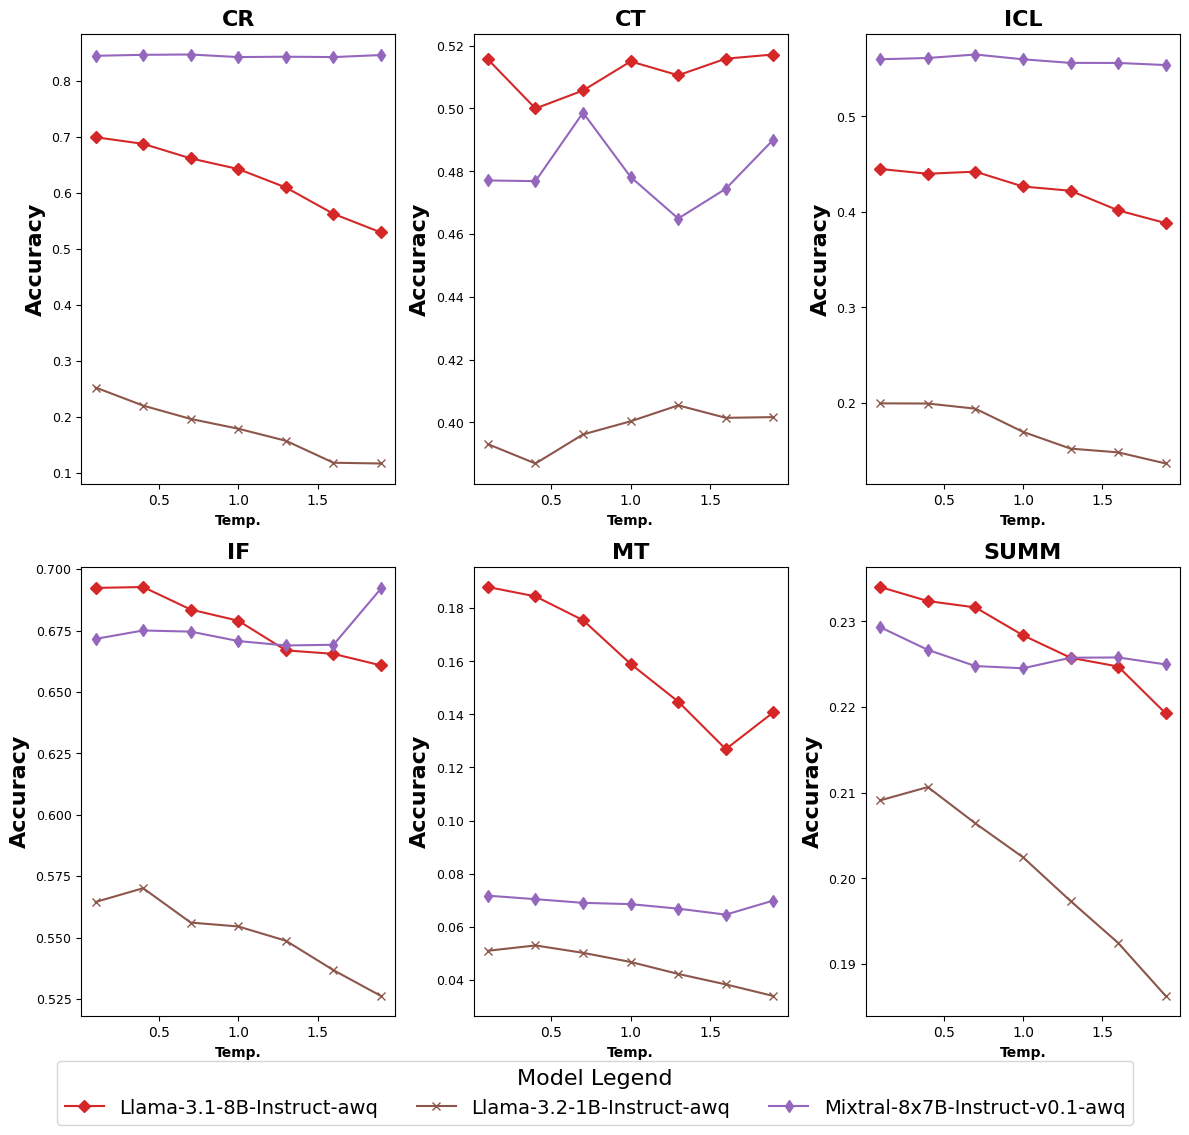

In [35]:
import matplotlib.pyplot as plt

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Llama-3.2-1B-Instruct": "C7",
    "Phi-3.5-mini-instruct": "C8",
    "Phi-3.5-mini-instruct": "C9",
    "Qwen2.5-1.5B-Instruct": "C10",
    "DeepSeek-R1-Distill-Llama-8B": "C11",
    "DeepSeek-R1-Distill-Qwen-7B": "C12",
    "Llama-3.1-8B-Instruct-awq": "C13",
    "Mixtral-8x7B-Instruct-v0.1-awq": "C14",
    "Llama-3.2-1B-Instruct-awq": "C15",
}
model_order = list(color_map.keys())

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]
model_marker_map = {model: markers[i] for i, model in enumerate(model_order)}


grouped = (
    df.groupby(["category", "tested_model", "temperature"])
    .accuracy.mean()
    .reset_index()
)

categories = grouped["category"].unique()

fig, axes = plt.subplots(2, 3, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.flatten()
added_labels = set()

for i, category in enumerate(categories[:6]):  # Adjust for a maximum of 6 categories
    ax = axes[i]
    subset = grouped[grouped["category"] == category]
    for model_name in subset["tested_model"].unique():
        model_data = subset[subset["tested_model"] == model_name]

        if model_name not in added_labels:
            ax.plot(
                model_data["temperature"],
                model_data["accuracy"],
                marker=model_marker_map[model_name],
                color=color_map[model_name],
                label=model_name,
            )
            added_labels.add(model_name)
        else:
            ax.plot(
                model_data["temperature"],
                model_data["accuracy"],
                marker=model_marker_map[model_name],
                color=color_map[model_name],
            )
    ax.set_title(category, fontsize=16, fontweight="bold")
    ax.set_xlabel("Temp.", fontsize=10, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=16, fontweight="bold")
    ax.tick_params(axis="y", labelsize=9)

# Remove empty subplots if categories < 6
for j in range(len(categories), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and add shared legend
plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=6,  # Adjust the number of columns in the legend to make it span the full width
    fontsize=14,  # Increase the font size of the legend
    title="Model Legend",
    title_fontsize=16,  # Increase the font size of the legend title
)

plt.savefig("temperature_eval_extend.svg")
plt.show()

/home/snt/miniconda3/envs/vllm_env_lujun/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

100%|===================| 172424/172522 [21:05<00:00]        

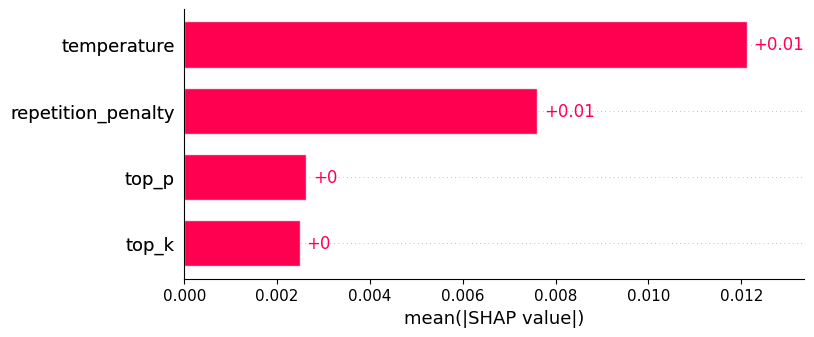

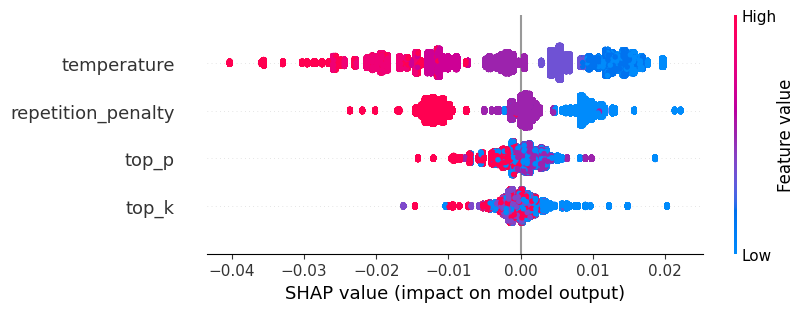

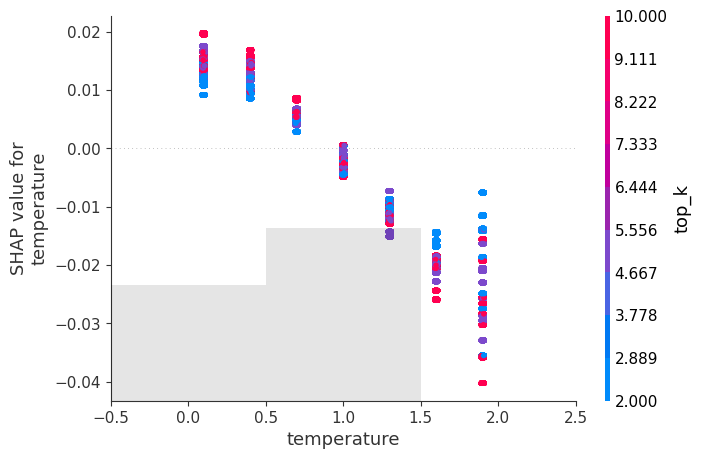

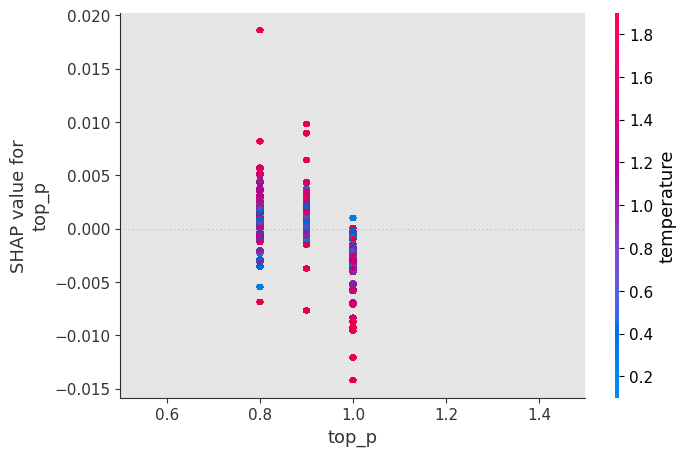

In [10]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


param_cols = ["top_p", "temperature", "repetition_penalty", "top_k"]
X = df[param_cols]
y = df["accuracy"] / 100 if df["accuracy"].max() > 1 else df["accuracy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. 拟合模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# 4. 创建 SHAP explainer
explainer = shap.Explainer(model, X_train)

# 5. 计算 SHAP 值
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)
shap.plots.scatter(shap_values[:, "temperature"], color=shap_values)
shap.plots.scatter(shap_values[:, "top_p"], color=shap_values)